In [1]:
include("../BayesianUtilities.jl")
using Distributions, LinearAlgebra, Plots, Random, .BayesianUtilities

In [2]:
Random.seed!(0);

In [3]:
# Synthetic data
A = [1 0.1; 0 1]
B = [1 0]
Q = [0.1^3/3 0.1^2/2; 0.1^2/2 0.1]
R = 1

T = 20

x_real = zeros(2,T)
y_real = zeros(T)

x_real[:,1] = rand(MvNormal(zeros(2),diagm(0=>ones(2))))
y_real[1] = rand(Normal((B*x_real[:,1])[1],R))
for t=2:T
    x_real[:,t] = rand(MvNormal(A*x_real[:,t-1],Q))
    y_real[t] = rand(Normal((B*x_real[:,t])[1],R))
end

In [4]:
y_real

20-element Array{Float64,1}:
  0.3261000257351814
  1.0568225415877555
  0.33488552774460556
  0.20351370657896806
  0.7479205504900681
 -1.2455230446004775
  1.27355957191447
  1.470783589024301
  1.3878938365272515
  1.1824394337610564
  2.7681297254308275
  2.9348123236782953
  4.2741749493826
  2.6142077124145726
  1.735733594535381
  3.3246104345825533
  4.669086124510816
  3.1551350999035694
  3.485116336997867
  3.1229126973273384

In [5]:
# Priors
p1 = MvNormal(zeros(2),diagm(0=>ones(2)))
pW = Wishart(2, diagm(0=>ones(2)))
;

In [6]:
function filter(qW, T)
    W = mean(qW)
    forward_estimates = Array{MvNormal}(undef, T)
    forward_estimates[1] = collide(p1,B\Normal(y_real[1],R))
    for t=2:T
        predict = A*forward_estimates[t-1] + MvNormal(zeros(2),inv(W))
        forward_estimates[t] = collide(predict,B\Normal(y_real[t],R))
    end
    return forward_estimates
end

function smooth(forward_estimates, qW, T)
    W = mean(qW)
    smooth_estimates = Array{MvNormal}(undef, T)
    smooth_estimates[T] = forward_estimates[T]
    joint_dists = Array{MvNormal}(undef, T-1)
    for t=T-1:-1:1
        smooth_estimates[t], joint_dists[t] = transit(forward_estimates[t],smooth_estimates[t+1],A,W)
    end
    return smooth_estimates, joint_dists
end
;

In [19]:
qW = pW # initial qW

n_its = 25
FE = zeros(n_its)
# Variational updates
for i=1:n_its
    # Update q(x_{1:T})
    forward_estimates = filter(qW,T)
    smooth_estimates, joint_dists = smooth(forward_estimates, qW, T)
    # Update qW
    qW = pW
    for t=1:T-1
        message = transit(smooth_estimates[t],smooth_estimates[t+1],joint_dists[t],A,nothing)
        qW = collide(qW,message)
    end
    # Calculate Free Energy
    F = -entropy(qW) - entropy(smooth_estimates[1])
    F += cross_entropy(qW,pW) + cross_entropy(smooth_estimates[1], p1)
    for t=1:T-1
        F -= normal_conditional_entropy(smooth_estimates[t], smooth_estimates[t+1], joint_dists[t])
        F += transit(smooth_estimates[t],smooth_estimates[t+1],joint_dists[t],A,qW)
    end
    FE[i] = F
end

In [20]:
inv(mean(qW))

2×2 Array{Float64,2}:
  0.275225    -0.00453641
 -0.00453641   0.426292

In [21]:
forward_estimates = filter(qW,T)
smooth_estimates, joint_dists = smooth(forward_estimates, qW, T)
;

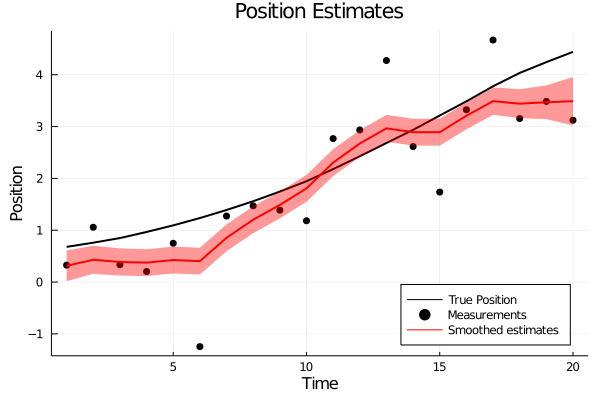

In [22]:
y_filter_m, y_filter_v = zeros(T), zeros(T)
y_smooth_m, y_smooth_v = zeros(T), zeros(T)
for t=1:T
    y_smooth_m[t] = mean(smooth_estimates[t])[1]
    y_smooth_v[t] = cov(smooth_estimates[t])[1,1]
end

plot(x_real[1,:], color=:black, lw=2, title="Position Estimates", xaxis="Time", yaxis="Position", label="True Position")
scatter!(collect(1:T), y_real, color=:black, xaxis="Time", yaxis="Position", label="Measurements")
plot!(y_smooth_m, lw=2, color=:red, ribbon=y_smooth_v, fillalpha=0.4, label="Smoothed estimates", legend=:bottomright)

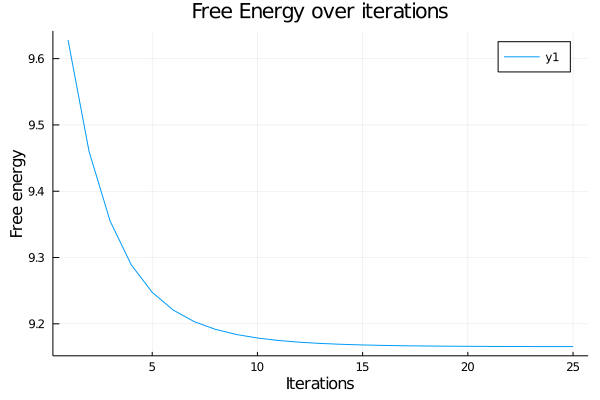

In [23]:
plot(FE, title="Free Energy over iterations", xlabel="Iterations", ylabel="Free energy")

In [24]:
FE

25-element Array{Float64,1}:
 9.628005411920398
 9.45982081297369
 9.354996621875506
 9.28917788076946
 9.247450182880101
 9.220666660205357
 9.203219658733705
 9.191667397277826
 9.183888215978772
 9.178563431717974
 9.174863520444916
 9.172258651668123
 9.170404438888532
 9.16907282734557
 9.168109968026691
 9.167410238116288
 9.166899972738806
 9.166527093199214
 9.16625436356081
 9.166054917252811
 9.165909231139612
 9.165803041522887
 9.165725885841615
 9.165670068286888
 9.165629917856199